
# Laminar flame speed sensitivity analysis

In this example we simulate a freely-propagating, adiabatic, premixed methane-air flame,
calculate its laminar burning velocity and perform a sensitivity analysis of its
kinetics with respect to each reaction rate constant.

Requires: cantera >= 3.0.0, pandas

.. tags:: Python, combustion, 1D flow, flame speed, premixed flame,
          sensitivity analysis, plotting

The figure below illustrates the setup, in a flame-fixed coordinate system. The
reactants enter with density $\rho_u$, temperature $T_u$ and speed
$S_u$. The products exit the flame at speed $S_b$, density $\rho_b$
and temperature $T_b$.

<img src="file://_static/images/samples/flame-speed.svg" width="50%" alt="Freely Propagating Flame" align="center">


In [3]:
import cantera as ct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True

## Simulation parameters



In [4]:
# Define the gas mixture and kinetics used to compute mixture properties
# In this case, we are using the GRI 3.0 model with methane as the fuel
mech_file = "gri30.yaml"
fuel_comp = {"CH4": 1.0}

# Inlet temperature in kelvin and inlet pressure in pascals
# In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = ct.one_atm

# Domain width in metres
width = 0.014

## Simulation setup



In [5]:
# Create the object representing the gas and set its state to match the inlet conditions
gas = ct.Solution(mech_file)
gas.TP = To, Po
gas.set_equivalence_ratio(1.0, fuel_comp, {"O2": 1.0, "N2": 3.76})

flame = ct.FreeFlame(gas, width=width)
flame.set_refine_criteria(ratio=3, slope=0.07, curve=0.14)

## Solve the flame



In [6]:
flame.solve(loglevel=1, auto=True)


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.455
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003649      4.425
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.653e-05       5.86
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.734e-05      6.005
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0006666      4.488
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.028 m
##############################################################################
Refining grid in flame.
    New points inserted after gri

In [8]:
print(f"\nmixture-averaged flame speed = {flame.velocity[0]:7f} m/s\n")


mixture-averaged flame speed = 0.380706 m/s



## Plot temperature and major species profiles

Check and see if all has gone well.



Text(0, 0.5, 'Temperature [K]')

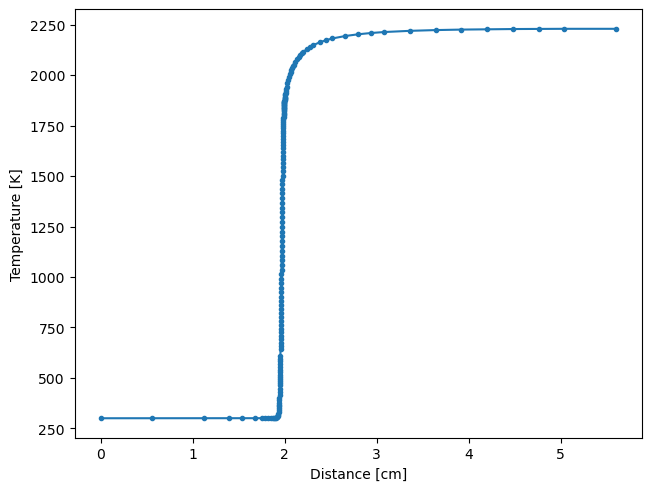

In [9]:
# Extract the spatial profiles as a SolutionArray to simplify plotting specific species
profile = flame.to_array()

fig, ax = plt.subplots()

ax.plot(profile.grid * 100, profile.T, ".-")
ax.set_xlabel("Distance [cm]")
ax.set_ylabel("Temperature [K]")

Text(0, 0.5, 'Mole fraction [-]')

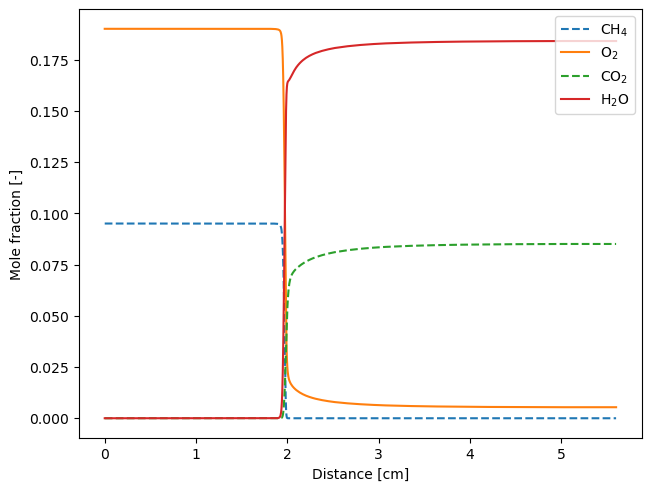

In [10]:
fig, ax = plt.subplots()

ax.plot(profile.grid * 100, profile("CH4").X, "--", label="CH$_4$")
ax.plot(profile.grid * 100, profile("O2").X, label="O$_2$")
ax.plot(profile.grid * 100, profile("CO2").X, "--", label="CO$_2$")
ax.plot(profile.grid * 100, profile("H2O").X, label="H$_2$O")

ax.legend(loc="best")
ax.set_xlabel("Distance [cm]")
ax.set_ylabel("Mole fraction [-]")

## Sensitivity Analysis

See which reactions affect the flame speed the most. The sensitivities can be
efficiently computed using the adjoint method. In the general case, we consider a
system $f(x, p) = 0$ where $x$ is the system's state vector and $p$
is a vector of parameters. To compute the sensitivities of a scalar function
$g(x, p)$ to the parameters, we solve the system:

\begin{align}\left(\frac{\partial f}{\partial x}\right)^T \lambda =
       \left(\frac{\partial g}{\partial x}\right)^T\end{align}

for the Lagrange multiplier vector $\lambda$. The sensitivities are then
computed as

\begin{align}\left.\frac{dg}{dp}\right|_{f=0} =
       \frac{\partial g}{\partial p} - \lambda^T \frac{\partial f}{\partial p}\end{align}

In the case of flame speed sensitivity to the reaction rate coefficients,
$g = S_u$ and $\partial g/\partial p = 0$. Since
$\partial f/\partial x$ is already computed as part of the normal solution
process, computing the sensitivities for $N$ reactions only requires $N$
additional evaluations of the residual function to obtain
$\partial f/\partial p$, plus the solution of the linear system for
$\lambda$.

Calculation of flame speed sensitivities with respect to rate coefficients is
implemented by the method `FreeFlame.get_flame_speed_reaction_sensitivities`. For
other sensitivities, the method `Sim1D.solve_adjoint` can be used.



In [11]:
# Create a DataFrame to store sensitivity-analysis data
sens = pd.DataFrame(index=gas.reaction_equations(), columns=["sensitivity"])

# Use the adjoint method to calculate sensitivities
sens.sensitivity = flame.get_flame_speed_reaction_sensitivities()

# Show the first 10 sensitivities
sens.head(10)

,sensitivity
2 O + M <=> O2 + M,-0.000164
H + O + M <=> OH + M,-0.000738
H2 + O <=> H + OH,0.027999
HO2 + O <=> O2 + OH,-0.004707
H2O2 + O <=> HO2 + OH,-0.000019
CH + O <=> CO + H,-0.001091
CH2 + O <=> H + HCO,-0.003906
CH2(S) + O <=> CO + H2,-0.000310
CH2(S) + O <=> H + HCO,-0.000057
CH3 + O <=> CH2O + H,-0.012579


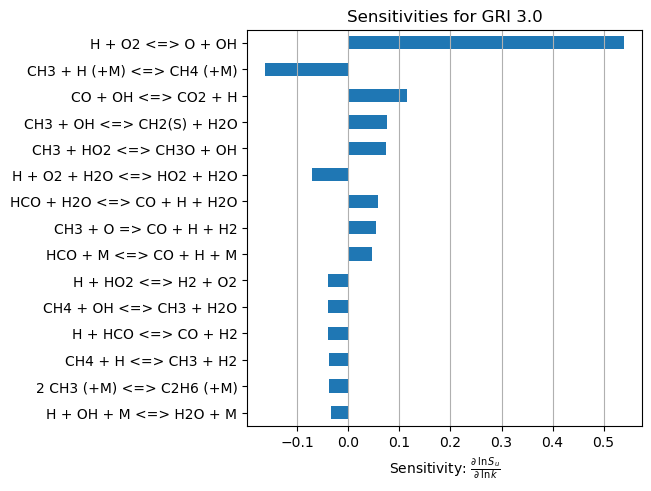

In [12]:
# Sort the sensitivities in order of descending magnitude
sens = sens.iloc[(-sens['sensitivity'].abs()).argsort()]

fig, ax = plt.subplots()

# Reaction mechanisms can contains thousands of elementary steps. Limit the plot
# to the top 15
sens.head(15).plot.barh(ax=ax, legend=None)

ax.invert_yaxis()  # put the largest sensitivity on top
ax.set_title("Sensitivities for GRI 3.0")
ax.set_xlabel(r"Sensitivity: $\frac{\partial\:\ln S_u}{\partial\:\ln k}$")
ax.grid(axis='x')